## Final Project Submission

Please fill out:
* Student name: Matthew E. Parker
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: Rafael Carrasco
* Blog post URL:

# Import libraries & Acquiring Data
First, import the necessary Python libraries and packages with which we will be working. Then, access the Kepler Telescope data using the Kepler API designed by NASA. 

Information about the Kepler Telescope API can be found at https://exoplanetarchive.ipac.caltech.edu/docs/program_interfaces.html

Information about the columns present in the "Objects of Interest" dataset can be found at https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html

Information about the columns present in the "Confirmed Exoplanets" dataset can be found at https://exoplanetarchive.ipac.caltech.edu/docs/API_exoplanet_columns.html

In [253]:
# for acquiring and managing datasets
import requests
import pandas as pd
from io import StringIO

# for math
import numpy as np
np.random.seed(42)

# for graphing
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

# for modeling
from sklearn.feature_selection import SelectKBest, SelectFpr, chi2
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.decomposition import PCA

# classifier modeling methods
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
# Use the NASA's Kepler API to acquire telescope data
url = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=cumulative"
response = requests.get(url)
url2 = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=exoplanets"
response2 = requests.get(url2)

In [3]:
# turn the API data into a usable format
data = StringIO(response.text)
df = pd.read_csv(data, index_col='kepoi_name')
data2 = StringIO(response2.text)
confirmed_planets_df = pd.read_csv(data2)

In [4]:
# adding additional parameters not included in the default dataset
url3 = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=cumulative&select=kepoi_name,koi_smet,koi_smass"
response3 = requests.get(url3)
data3 = StringIO(response3.text)
df3 = pd.read_csv(data3, index_col='kepoi_name')
display(df3.head())
df3.info()

,koi_smet,koi_smass
kepoi_name,,
K00752.01,0.14,0.919
K00752.02,0.14,0.919
K00753.01,-0.18,0.961
K00754.01,-0.52,0.836
K00755.01,0.07,1.095


<class 'pandas.core.frame.DataFrame'>
Index: 9564 entries, K00752.01 to K07989.01
Data columns (total 2 columns):
koi_smet     9178 non-null float64
koi_smass    9201 non-null float64
dtypes: float64(2)
memory usage: 224.2+ KB


In [5]:
# merge the two datasets
df = pd.concat([df, df3], axis=1)

In [6]:
display(df.head())
df.info()

,kepid,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,...,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra_str,dec_str,koi_kepmag,koi_kepmag_err,koi_smet,koi_smass
kepoi_name,,,,,,,,,,,,,,,,,,,,,
K00752.01,10797460,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,9.488036,...,-0.096,0.927,0.105,-0.061,19h27m44.22s,+48d08m29.9s,15.347,NaN,0.14,0.919
K00752.02,10797460,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,54.418383,...,-0.096,0.927,0.105,-0.061,19h27m44.22s,+48d08m29.9s,15.347,NaN,0.14,0.919
K00753.01,10811496,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,19.899140,...,-0.176,0.868,0.233,-0.078,19h48m01.16s,+48d08m02.9s,15.436,NaN,-0.18,0.961
K00754.01,10848459,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,1.736952,...,-0.168,0.791,0.201,-0.067,19h02m08.31s,+48d17m06.8s,15.597,NaN,-0.52,0.836
K00755.01,10854555,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,2.525592,...,-0.210,1.046,0.334,-0.133,19h15m01.17s,+48d13m34.3s,15.509,NaN,0.07,1.095


<class 'pandas.core.frame.DataFrame'>
Index: 9564 entries, K00752.01 to K07989.01
Data columns (total 51 columns):
kepid                9564 non-null int64
kepler_name          2305 non-null object
koi_disposition      9564 non-null object
koi_pdisposition     9564 non-null object
koi_score            8054 non-null float64
koi_fpflag_nt        9564 non-null int64
koi_fpflag_ss        9564 non-null int64
koi_fpflag_co        9564 non-null int64
koi_fpflag_ec        9564 non-null int64
koi_period           9564 non-null float64
koi_period_err1      9110 non-null float64
koi_period_err2      9110 non-null float64
koi_time0bk          9564 non-null float64
koi_time0bk_err1     9110 non-null float64
koi_time0bk_err2     9110 non-null float64
koi_impact           9201 non-null float64
koi_impact_err1      9110 non-null float64
koi_impact_err2      9110 non-null float64
koi_duration         9564 non-null float64
koi_duration_err1    9110 non-null float64
koi_duration_err2    9110 non-null flo

# Scrub the data

In [7]:
# remove columns with no data
df.drop(['koi_teq_err1', 'koi_teq_err2','koi_kepmag_err'], axis=1, inplace=True)

In [8]:
# condensed data, dropping error columns and non-data columns for simplicity of this project
errors = ['koi_period_err1','koi_period_err2','koi_time0bk_err1','koi_time0bk_err2',
          'koi_impact_err1','koi_impact_err2','koi_duration_err1','koi_duration_err2',
          'koi_depth_err1','koi_depth_err2','koi_prad_err1','koi_prad_err2',
          'koi_insol_err1','koi_insol_err2','koi_steff_err1','koi_steff_err2',
          'koi_slogg_err1','koi_slogg_err2','koi_srad_err1','koi_srad_err2']
descriptors = ['kepid','kepler_name','koi_disposition','koi_score',
               'koi_tce_delivname','ra_str','dec_str']
df_descriptors = df[['kepid','kepler_name','koi_disposition','koi_score','koi_tce_delivname','ra_str','dec_str']]

df_original = df.copy() #creating a backup copy in case its needed later
df = df.drop(errors, axis=1)
df = df.drop(descriptors, axis=1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9564 entries, K00752.01 to K07989.01
Data columns (total 21 columns):
koi_pdisposition    9564 non-null object
koi_fpflag_nt       9564 non-null int64
koi_fpflag_ss       9564 non-null int64
koi_fpflag_co       9564 non-null int64
koi_fpflag_ec       9564 non-null int64
koi_period          9564 non-null float64
koi_time0bk         9564 non-null float64
koi_impact          9201 non-null float64
koi_duration        9564 non-null float64
koi_depth           9201 non-null float64
koi_prad            9201 non-null float64
koi_teq             9201 non-null float64
koi_insol           9243 non-null float64
koi_model_snr       9201 non-null float64
koi_tce_plnt_num    9218 non-null float64
koi_steff           9201 non-null float64
koi_slogg           9201 non-null float64
koi_srad            9201 non-null float64
koi_kepmag          9563 non-null float64
koi_smet            9178 non-null float64
koi_smass           9201 non-null float64
dtypes: floa

In [10]:
# drop rows containing NaN values
df.dropna(inplace=True)

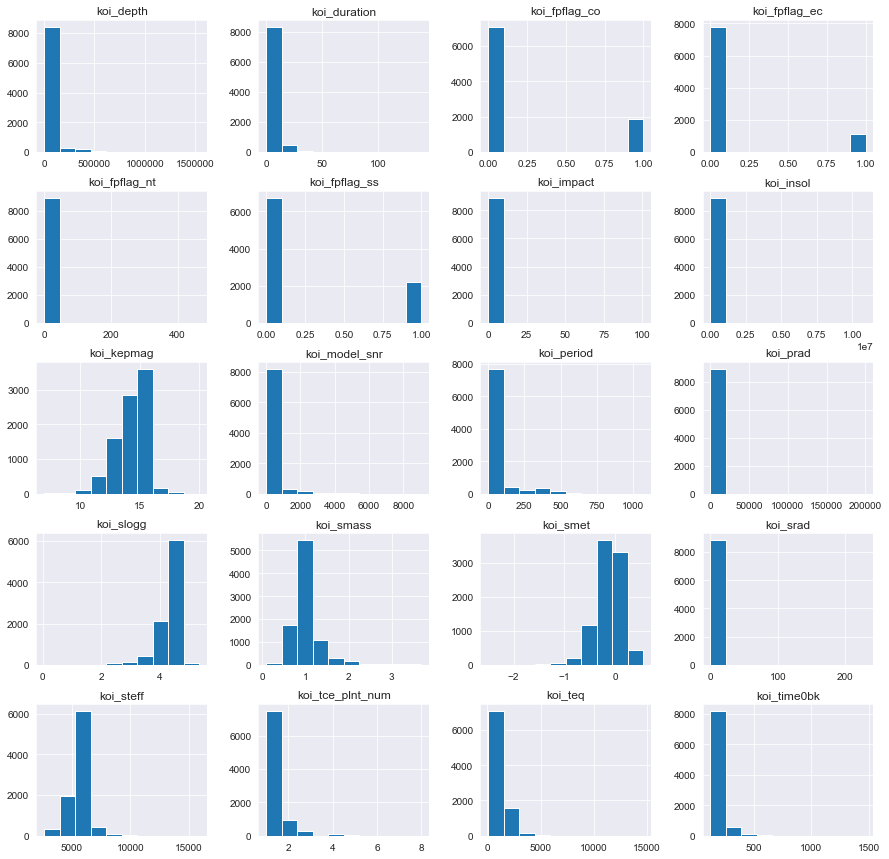

In [11]:
# examine the distributions for each variable
df.hist(figsize=(15,15));

**It looks like there are probably some outliers or other peculiar values in the data. Let's explore these, then get rid of outliers.**

In [12]:
continuous_data = ['koi_period','koi_time0bk','koi_impact','koi_duration','koi_depth',
                   'koi_prad','koi_teq','koi_insol','koi_model_snr','koi_steff','koi_srad']

In [13]:
new_df = df.copy()

# removing outliers and peculiar data
indexNames = new_df[(new_df['koi_depth'] >= 4000) |
                    (new_df['koi_duration'] >= 30) |
                    (new_df['koi_fpflag_nt'] >= 200) |
                    (new_df['koi_impact'] >= 1.5) |
                    (new_df['koi_insol'] >= 4500) |
                    (new_df['koi_model_snr'] >= 160) |
                    (new_df['koi_period'] >= 600) |
                    (new_df['koi_prad'] >= 50) |
                    (new_df['koi_smet'] < -1.25) |
                    (new_df['koi_srad'] > 4) |
                    (new_df['koi_steff'] >= 8500) |
                    (new_df['koi_teq'] >= 7500) |
                    (new_df['koi_time0bk'] >= 500)].index
new_df.drop(indexNames, inplace=True)

print(len(new_df))

6022


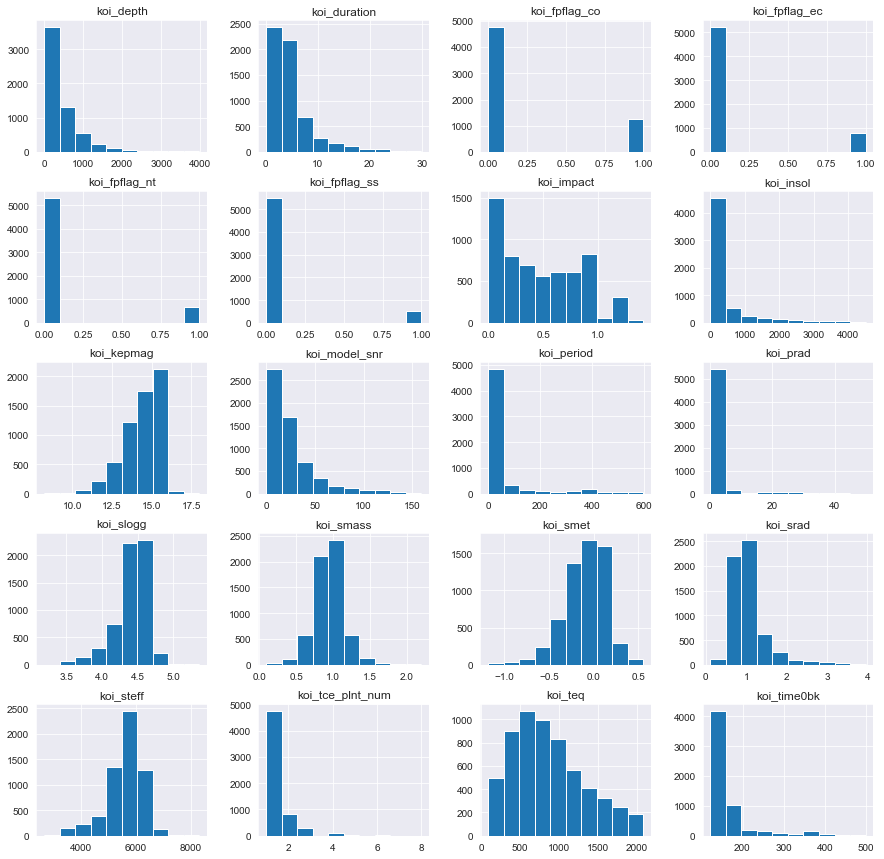

In [14]:
new_df.hist(figsize=(15,15));

**Though our elimination of NaNs and outliers reduced our dataset by over 30%, we still have over 6,000 observations, which should be more than enough to build a model.**

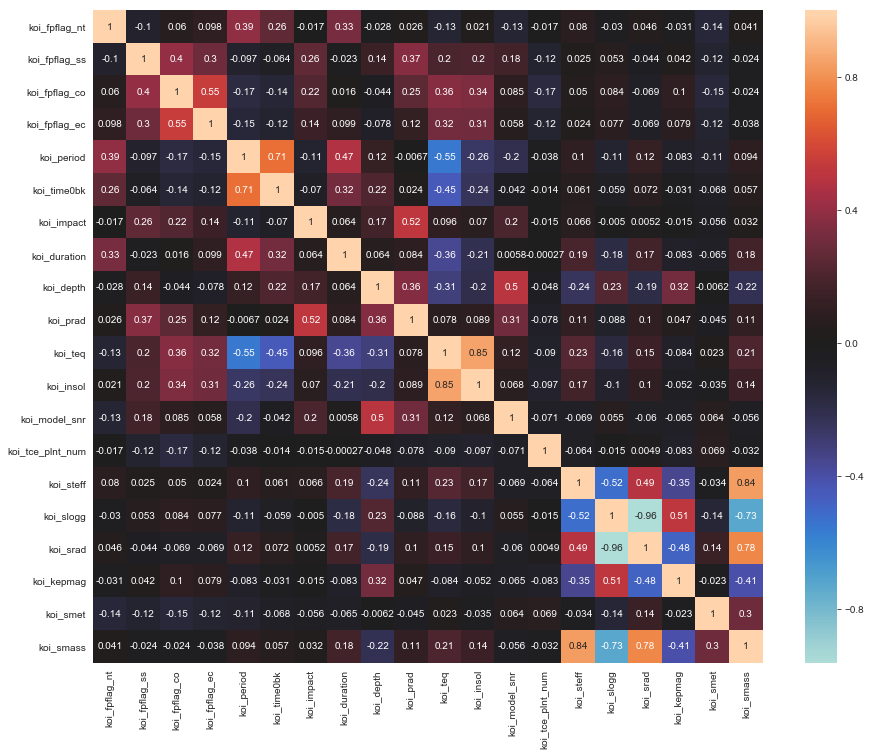

In [15]:
# look for multicollinearity
corr = new_df.corr()
plt.figure(figsize=(15,12))
sns.heatmap(corr, center=0, annot=True);

It seems there are a few instances of high multicollinearity in your dataset. Looking back to the Kepler API information website, it seems that `koi_teq` and `koi_insol` are two measures of the same thing (surface temperature), so we can safely remove one of those. It also seems that `koi_period` and `koi_time0bk` measure similar things, so we'll also drop one of those. 

We will also drop `koi_tce_plnt_num`, `koi_fpflag_nt`, `koi_fpflag_ss`, `koi_fpflag_co`, and `koi_fpflag_ec` since they are the results of analyis, not observations themselves.

In [16]:
new_df.drop(columns=['koi_insol','koi_time0bk','koi_tce_plnt_num', 'koi_fpflag_nt', 
                     'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec'], inplace=True)

The other multicollinear variables (`koi_steff`, `koi_slogg`, `koi_srad`, with `koi_smass` and `koi_period` with `koi_teq`) will be kept. Although they are very correlated, each one sounds like it could be an impactful measure in its own right. There are other instances of less severe multicollinearity (correlation score < |.6| ), but we will have to address these and the other multicollinear features we kept through weighting and feature engineering.



### Scaling the data & Encoding labels

In [17]:
target = new_df.koi_pdisposition
variables = new_df.drop('koi_pdisposition', axis=1)

In [18]:
target.index

Index(['K00752.01', 'K00752.02', 'K00755.01', 'K00756.01', 'K00756.02',
       'K00756.03', 'K00114.01', 'K00112.02', 'K00746.01', 'K00747.01',
       ...
       'K08192.01', 'K08193.01', 'K08194.01', 'K08195.01', 'K08196.01',
       'K08197.01', 'K08198.01', 'K07984.01', 'K07986.01', 'K07989.01'],
      dtype='object', name='kepoi_name', length=6022)

In [19]:
# encoding labels
le = LabelEncoder()
labels = pd.DataFrame(le.fit_transform(target), columns=['koi_pdisposition'], index=target.index)

In [20]:
# scaling features
scaler = StandardScaler()
features = pd.DataFrame(scaler.fit_transform(variables), columns=variables.columns)

# Exploring the Data

In [21]:
features.describe()

,koi_period,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_model_snr,koi_steff,koi_slogg,koi_srad,koi_kepmag,koi_smet,koi_smass
count,6.022000e+03,6.022000e+03,6.022000e+03,6.022000e+03,6.022000e+03,6.022000e+03,6.022000e+03,6.022000e+03,6.022000e+03,6.022000e+03,6.022000e+03,6.022000e+03,6.022000e+03
mean,-5.663575e-17,-4.247682e-17,1.887858e-16,7.551434e-17,-1.274304e-16,6.607505e-17,-3.775717e-17,3.775717e-16,2.086084e-15,-2.831788e-17,-5.645877e-16,-7.551434e-17,8.495363e-17
std,1.000083e+00,1.000083e+00,1.000083e+00,1.000083e+00,1.000083e+00,1.000083e+00,1.000083e+00,1.000083e+00,1.000083e+00,1.000083e+00,1.000083e+00,1.000083e+00,1.000083e+00
min,-5.012563e-01,-1.317254e+00,-1.117587e+00,-8.871353e-01,-5.441111e-01,-1.685934e+00,-1.053845e+00,-4.393830e+00,-5.136694e+00,-2.014913e+00,-5.123308e+00,-4.445601e+00,-3.961596e+00
25%,-4.709837e-01,-9.275497e-01,-6.012356e-01,-6.352701e-01,-3.694908e-01,-7.798064e-01,-6.252131e-01,-4.744455e-01,-3.596411e-01,-5.416870e-01,-5.943075e-01,-5.344637e-01,-5.742023e-01
50%,-4.105843e-01,-1.413563e-01,-3.228603e-01,-3.473977e-01,-2.724796e-01,-1.685467e-01,-3.758269e-01,1.596222e-01,2.432879e-01,-2.360821e-01,2.247935e-01,3.591055e-02,6.626581e-03
75%,-1.793037e-01,8.255390e-01,1.896939e-01,2.555382e-01,-1.253459e-01,6.105942e-01,2.398451e-01,6.667266e-01,6.227537e-01,2.044104e-01,7.771912e-01,6.877668e-01,5.038161e-01
max,4.619697e+00,2.566773e+00,5.752999e+00,6.492867e+00,7.511055e+00,2.612254e+00,5.153531e+00,4.065899e+00,4.016864e+00,6.090993e+00,2.959534e+00,2.643336e+00,5.810269e+00


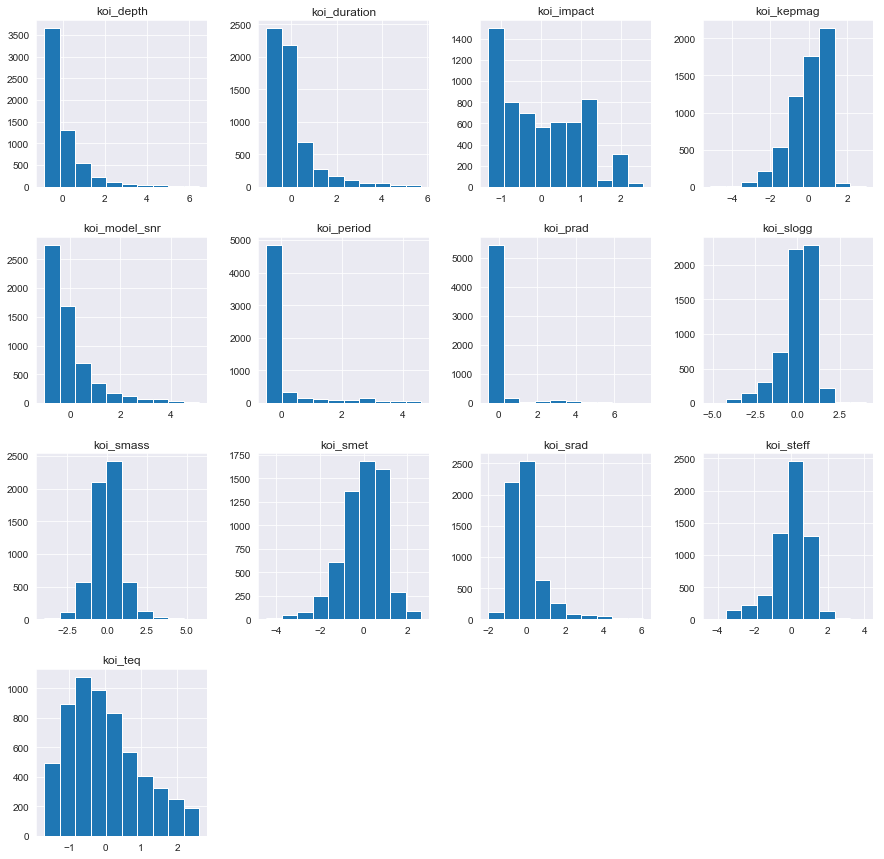

In [22]:
features.hist(figsize=(15,15));

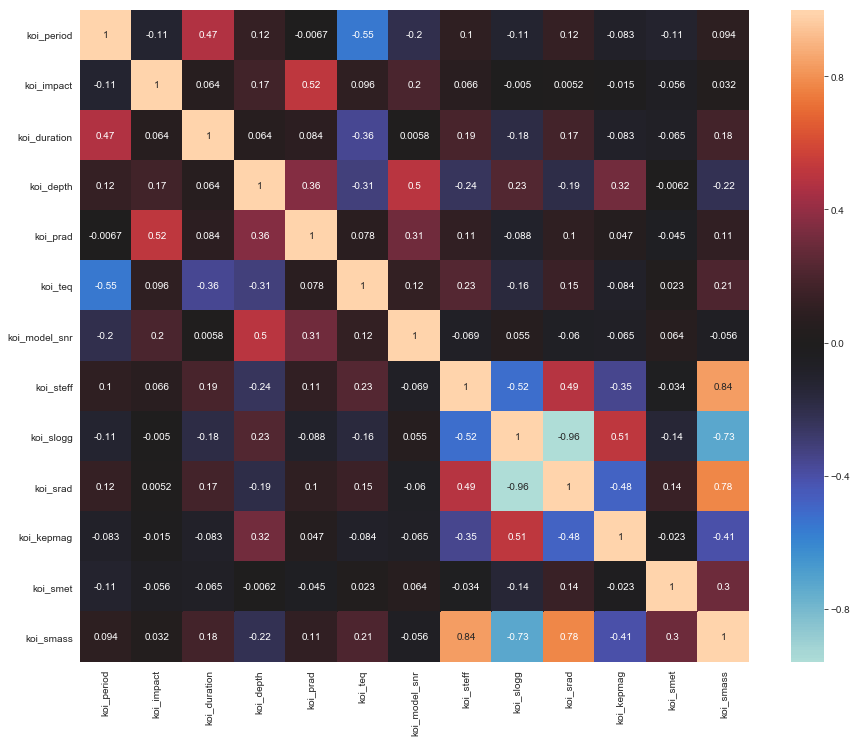

In [23]:
# look at correlation heatmap
corr = features.corr()
plt.figure(figsize=(15,12))
sns.heatmap(corr, center=0, annot=True);

In [67]:
def plot_feature_importances(features_train, model):
    n_features = model.n_features_
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), features_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature");

# Modeling the data

### Train, test, split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=42)

### Principal Component Analysis

First, we need to determine how many engineered features are required in order to explain at least 95% of the variance in the dataset. We can do this using Principal Component Analysis.

10

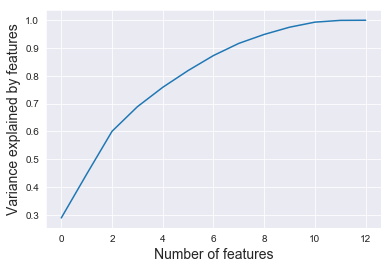

In [31]:
# perfrom Principal Component Analysis to determine how many features
# will explain 95% of model variance
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
variance = pca.explained_variance_ratio_.cumsum()
plt.plot(range(X_train_pca.shape[1]), variance)
plt.xlabel("Number of features", fontsize=14)
plt.ylabel("Variance explained by features", fontsize=14);

n_features = len(variance[variance <= .95]) + 1
n_features

**So it looks like using 10 features will explain 95% of the variance in our data.**

### Building pipelines to compare classification methods

In [139]:
classifiers = [KNeighborsClassifier, SVC, DecisionTreeClassifier, RandomForestClassifier, AdaBoostClassifier, XGBClassifier]

In [140]:
classy_scores = []
for clf in classifiers:
    pipe = Pipeline([
                     ('pca', PCA(n_components=n_features)),
                     ('clf', clf()) ])
    pipe.fit(X_train, y_train.koi_pdisposition.values)
    score = pipe.score(X_test, y_test.koi_pdisposition.values)
    classy_scores.append((clf, score))
ranked_classifiers = sorted(classy_scores, key=lambda x: x[1], reverse=True)

ranked_classifiers

C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[(xgboost.sklearn.XGBClassifier, 0.8260292164674635),
 (sklearn.svm.classes.SVC, 0.8227091633466136),
 (sklearn.ensemble.forest.RandomForestClassifier, 0.8193891102257637),
 (sklearn.ensemble.weight_boosting.AdaBoostClassifier, 0.8127490039840638),
 (sklearn.neighbors.classification.KNeighborsClassifier, 0.8094289508632138),
 (sklearn.svm.classes.LinearSVC, 0.8081009296148738),
 (sklearn.tree.tree.DecisionTreeClassifier, 0.7410358565737052)]

**It appears that the most promising methods are XGBoost and Support Vector Classification.**

In [34]:
# clf = xgb.XGBClassifier()
# clf.fit(X_train, y_train)
# training_preds = clf.predict(X_train)
# val_preds = clf.predict(X_test)
# training_accuracy = accuracy_score(y_train, training_preds)
# val_accuracy = accuracy_score(y_test, val_preds)

# print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
# print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

### Begin tuning parameters for XGBoost

Many thanks to this site: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/ for providing a walkthrough to tuning XGBoost parameters.

In [133]:
# building a model with default parameters
xgb = XGBClassifier(learning_rate=0.1, n_estimators=100, nthread=4, subsample=.8,
                    col_sample_bytree=.8, random_state=42, objective='binary:logistic')
xgb_pipe = Pipeline(steps=[('pca', PCA(n_components=n_features)), 
                           ('xgb', xgb)])
xgb_params = {}
clf_xgb = GridSearchCV(xgb_pipe, xgb_params, cv=5)
clf_xgb.fit(X_train, y_train.koi_pdisposition.values)
print('Train Score:', clf_xgb.score(X_train,y_train.koi_pdisposition.values))
print('Test Score:', clf_xgb.score(X_test,y_test.koi_pdisposition.values))
print('\nBest max_depth:', clf_xgb.best_estimator_.get_params()['xgb__max_depth'])
print('Best min_child_weight:', clf_xgb.best_estimator_.get_params()['xgb__min_child_weight'])
print('Best gamma:', clf_xgb.best_estimator_.get_params()['xgb__gamma'])

Score: 0.8399025686448184
Best max_depth: 3
Best min_child_weight: 1
Best gamma: 0
Training Accuracy: 83.99%
Validation accuracy: 82.27%


In [127]:
# Tuning max_depth, min_child_weight
xgb = XGBClassifier(learning_rate=0.1, n_estimators=100, nthread=4, subsample=.8,
                    col_sample_bytree=.8, random_state=42, objective='binary:logistic')
xgb_pipe = Pipeline(steps=[('pca', PCA(n_components=n_features)), 
                           ('xgb', xgb)])
xgb_params = {'xgb__max_depth': range(4, 11),
              'xgb__min_child_weight': range(2, 10),
             }
clf_xgb = GridSearchCV(xgb_pipe, xgb_params, cv=5)
clf_xgb.fit(X_train, y_train.koi_pdisposition.values)
print('Train Score:', clf_xgb.score(X_train,y_train.koi_pdisposition.values))
print('Test Score:', clf_xgb.score(X_test,y_test.koi_pdisposition.values))
print('\nBest max_depth:', clf_xgb.best_estimator_.get_params()['xgb__max_depth'])
print('Best min_child_weight:', clf_xgb.best_estimator_.get_params()['xgb__min_child_weight'])

Score: 0.962577502214349
Best max_depth: 9
Best min_child_weight: 4
Best gamma: 0


In [129]:
# Tuning gamma and max_depth (further)
xgb = XGBClassifier(learning_rate=0.1, n_estimators=100, nthread=4, subsample=.8,
                    col_sample_bytree=.8, random_state=42, objective='binary:logistic',
                    max_depth=9, min_child_weight=4)
xgb_pipe = Pipeline(steps=[('pca', PCA(n_components=n_features)), 
                           ('xgb', xgb)])
xgb_params = {'xgb__max_depth': [9, 10],
              'xgb__gamma': [0, .1, .2],
             }
clf_xgb = GridSearchCV(xgb_pipe, xgb_params, cv=5)
clf_xgb.fit(X_train, y_train.koi_pdisposition.values)
print('TrainScore:', clf_xgb.score(X_train,y_train.koi_pdisposition.values))
print('Test Score:', clf_xgb.score(X_test,y_test.koi_pdisposition.values))

print('\nBest max_depth:', clf_xgb.best_estimator_.get_params()['xgb__max_depth'])
print('Best min_child_weight:', clf_xgb.best_estimator_.get_params()['xgb__min_child_weight'])
print('Best gamma:', clf_xgb.best_estimator_.get_params()['xgb__gamma'])

Score: 0.962356067316209
Best max_depth: 9
Best min_child_weight: 4
Best gamma: 0


In [131]:
# Tuning reg_alpha and reg_lambda
xgb = XGBClassifier(learning_rate=0.1, n_estimators=100, nthread=4, subsample=.8,
                    col_sample_bytree=.8, random_state=42, objective='binary:logistic',
                    max_depth=9, min_child_weight=4, gamma=0)
xgb_pipe = Pipeline(steps=[('pca', PCA(n_components=n_features)), 
                           ('xgb', xgb)])
xgb_params = {'xgb__reg_alpha': [0, .05, .1],
              'xgb__reg_lambda': [.8, .9, 1],
             }
clf_xgb = GridSearchCV(xgb_pipe, xgb_params, cv=5)
clf_xgb.fit(X_train, y_train.koi_pdisposition.values)
print('TrainScore:', clf_xgb.score(X_train,y_train.koi_pdisposition.values))
print('Test Score:', clf_xgb.score(X_test,y_test.koi_pdisposition.values))

print('\nBest max_depth:', clf_xgb.best_estimator_.get_params()['xgb__max_depth'])
print('Best min_child_weight:', clf_xgb.best_estimator_.get_params()['xgb__min_child_weight'])
print('Best gamma:', clf_xgb.best_estimator_.get_params()['xgb__gamma'])
print('Best reg_alpha:', clf_xgb.best_estimator_.get_params()['xgb__reg_alpha'])
print('Best reg_lambda:', clf_xgb.best_estimator_.get_params()['xgb__reg_lambda'])

Score: 0.9645704162976085
Best max_depth: 9
Best min_child_weight: 4
Best gamma: 0
Best reg_alpha: 0
Best reg_lambda: 0.9


In [134]:
# instantiating classifier with best parameters
xgb = XGBClassifier(learning_rate=0.01, n_estimators=1000, nthread=4, subsample=.8,
                    col_sample_bytree=.8, random_state=42, objective='binary:logistic',
                    max_depth=9, min_child_weight=4, gamma=0, reg_alpha=0, reg_lambda=.9)
xgb_pipe = Pipeline(steps=[('pca', PCA(n_components=n_features)), 
                           ('xgb', xgb)])
xgb_params = {}
clf_xgb = GridSearchCV(xgb_pipe, xgb_params, cv=5)
clf_xgb.fit(X_train, y_train.koi_pdisposition.values)

print('TrainScore:', clf_xgb.score(X_train,y_train.koi_pdisposition.values))
print('Test Score:', clf_xgb.score(X_test,y_test.koi_pdisposition.values))

Training Accuracy: 96.46%
Validation accuracy: 82.67%


So, now we know that our best XGBoost parameters are:
    - learning_rate=0.01
    - n_estimators=1000
    - nthread=4
    - subsample=.8
    - col_sample_bytree=.8
    - random_state=42
    - objective='binary:logistic'
    - max_depth=9
    - min_child_weight=4
    - gamma=0
    - reg_alpha=0
    - reg_lambda=.9
    
`xgb = XGBClassifier(learning_rate=0.01, n_estimators=1000, nthread=4, subsample=.8, col_sample_bytree=.8, random_state=42, objective='binary:logistic', max_depth=9, min_child_weight=4, gamma=0, reg_alpha=0, reg_lambda=.9)`

### Begin tuning parameters for SVM

In [149]:
# building a model with default parameters, testing two different kernels
svc = SVC(random_state=42)
svc_pipe = Pipeline(steps=[('pca', PCA(n_components=n_features)), 
                           ('svc', svc)])
svc_params = {}

clf_svc = GridSearchCV(svc_pipe, svc_params, cv=5)
clf_svc.fit(X_train, y_train.koi_pdisposition.values)
print('Train Score:', clf_svc.score(X_train,y_train.koi_pdisposition.values))
print('Test Score:', clf_svc.score(X_test,y_test.koi_pdisposition.values))

C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Matthew

Score: 0.8394596988485385
Best kernel: rbf

Training Accuracy: 83.95%
Validation Accuracy: 82.27%


In [150]:
# tuning hyperparameters
svc = SVC(random_state=42)
svc_pipe = Pipeline(steps=[('pca', PCA(n_components=n_features)), 
                           ('svc', svc)])
svc_params = {'svc__kernel': ['linear','rbf'],
              'svc__C': [1, 10, 20],
              'svc__class_weight': [None,'balanced'],
              'svc__gamma': ['auto','scale']
             }

clf_svc = GridSearchCV(svc_pipe, svc_params, cv=5)
clf_svc.fit(X_train, y_train.koi_pdisposition.values)
print('Train Score:', clf_svc.score(X_train,y_train.koi_pdisposition.values))
print('Test Score:', clf_svc.score(X_test,y_test.koi_pdisposition.values))
print('\nBest kernel:', clf_svc.best_estimator_.get_params()['svc__kernel'])
print('Best C:', clf_svc.best_estimator_.get_params()['svc__C'])
print('Best class_weight:', clf_svc.best_estimator_.get_params()['svc__class_weight'])
print('Best gamma:', clf_svc.best_estimator_.get_params()['svc__gamma'])

Score: 0.8846324180690877
Best kernel: rbf
Best C: 10
Best class_weight: None
Best gamma: auto

Training Accuracy: 88.46%
Validation Accuracy: 83.07%


In [183]:
# instantiating classifier with best parameters
svc = SVC(kernel='rbf', C=10, class_weight=None, gamma='auto', random_state=42)
svc_pipe = Pipeline(steps=[('pca', PCA(n_components=n_features)), 
                           ('svc', svc)])
svc_params = {}
clf_svc = GridSearchCV(svc_pipe, svc_params, cv=5)

**Only marginal improvement, but still better nonetheless.** Thus, our ideal parameters for SVC are:
    - kernel='rbf'
    - C=10
    - class_weight=None
    - gamma='auto'
`svc = SVC(kernel='rbf', C=10, class_weight=None, gamma='auto', random_state=42)`

## Use Stacking

Here's some articles on it:
    - https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/
    - http://blog.kaggle.com/2016/12/27/a-kagglers-guide-to-model-stacking-in-practice/

In [219]:
def Stacking(model, train, test, y, n_fold):
    folds = StratifiedKFold(n_splits=n_fold, random_state=42)
    test_pred = np.empty((0,1), float)
    train_pred = np.empty((0,1), float)
    for train_indices, val_indices in folds.split(train, y.values):
        x_tr, x_val = train.iloc[train_indices], train.iloc[val_indices]
        y_tr, y_val = y.iloc[train_indices], y.iloc[val_indices]
        model.fit(x_tr, y_tr)
        train_pred = np.append(train_pred, model.predict(x_val))
    test_pred = np.append(test_pred, model.predict(test))
    return test_pred, train_pred

In [220]:
#base model 1 (XGBoostClassifier)
model1 = clf_xgb

test_pred1, train_pred1 = Stacking(model=model1, n_fold=10, train=X_train,
                                   test=X_test, y=y_train.koi_pdisposition)

train_pred1 = pd.DataFrame(train_pred1)
test_pred1 = pd.DataFrame(test_pred1)

In [222]:
#base model 2 (SVC)
model2 = clf_svc

test_pred2, train_pred2 = Stacking(model=model2, n_fold=10, train=X_train,
                                   test=X_test, y=y_train.koi_pdisposition)

train_pred2 = pd.DataFrame(train_pred2)
test_pred2 = pd.DataFrame(test_pred2)

In [270]:
# stacking a new model (LogisticRegression) on top of the two bases
df_stack = pd.concat([train_pred1, train_pred2], axis=1)
df_stack.columns = ['xgb','svc']
df_stack_test = pd.concat([test_pred1, test_pred2], axis=1)
df_stack_test.columns = ['xgb','svc']

model_stack = LogisticRegression(solver='lbfgs')
model_stack.fit(df_stack, y_train.koi_pdisposition)
model_stack.score(df_stack_test, y_test.koi_pdisposition)

0.8160690571049137

In [272]:
# tuning stacked model hyperparameters
stack_params = {'C': [1, 10],
                'class_weight': [None, 'balanced'],
                'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
               }
clf_stack = GridSearchCV(model_stack, stack_params, cv=5)
clf_stack.fit(df_stack, y_train.koi_pdisposition.values)
print('Test Score:', clf_stack.score(df_stack_test, y_test.koi_pdisposition))
print('Best C:', clf_stack.best_estimator_.get_params()['C'])
print('Best class_weight:', clf_stack.best_estimator_.get_params()['class_weight'])
print('Best solver:', clf_stack.best_estimator_.get_params()['solver'])

Test Score: 0.8227091633466136
Best C: 1
Best class_weight: balanced
Best solver: newton-cg


## Sigh...

Well, despite a lot of effort, it seems that using a Support Vector Classifier by itself outperforms both XGBoost and Model Stacking. 

In [273]:
# create a function to automate model fitting and visualizing feature importance
def modelfit(alg, x_tr, y_tr, x_tst, y_tst, n_estims=1000, early_stopping_rounds=50):
    xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(x_tr, label=y_tr)
    cvresult = xgb.cv(xgb_param, xgtrain,
                      num_boost_round=n_estims,
                      nfold=5, metrics='auc',
                      early_stopping_rounds=early_stopping_rounds)
    alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(x_tr, y_tr, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(x_tr)
    dtrain_predprob = alg.predict_proba(x_tr)[:,1]
    #Predict testing set:
    dtest_predictions = alg.predict(x_tst)
    dtest_predprob = alg.predict_proba(x_tst)[:,1]

        
    #Print model report:
    print("Model Report")
    print(f"Num. of estimators : {cvresult.shape[0]}")
    print(f"Train Accuracy : {metrics.accuracy_score(y_tr, dtrain_predictions)}")
    print(f"AUC Score (Train): {metrics.roc_auc_score(y_tr, dtrain_predprob)}")
    print(f"Test Accuracy : {metrics.accuracy_score(y_tst, dtest_predictions)}")
    print(f"AUC Score (Test): {metrics.roc_auc_score(y_tst, dtest_predprob)}")

    feat_imp = pd.Series(alg.get_booster()\
                         .get_score(importance_type='weight'))\
                         .sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

Model Report
Num. of estimators : 248
Train Accuracy : 0.8979185119574845
AUC Score (Train): 0.9565092115102433
Test Accuracy : 0.8173970783532537
AUC Score (Test): 0.8962502544448168


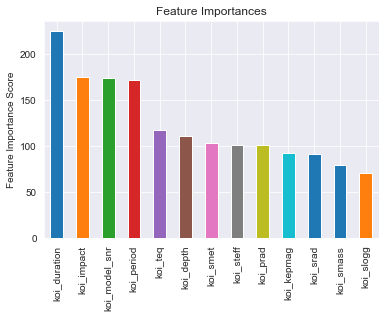

In [274]:
xgb1 = XGBClassifier(learning_rate=0.1,
                     n_estimators=1000,
                     objective='binary:logistic',
                     nthread=4,
                     scale_pos_weight=1,
                     seed=42)
modelfit(xgb1, X_train, y_train.koi_pdisposition.values,
         X_test, y_test.koi_pdisposition.values, 1000)

In [276]:
# Tuning max_depth and min_child_weight
param_test1 = {'max_depth':range(3,10), 'min_child_weight':range(1,6)}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, 
                                                  n_estimators=248, 
                                                  objective='binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1, 
                                                  seed=42), 
                        param_grid = param_test1, 
                        scoring='roc_auc',n_jobs=4, iid=False, cv=5)
gsearch1.fit(X_train, y_train.koi_pdisposition.values)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 6, 'min_child_weight': 2}, 0.893171265861233)

**Now we have our optimal `max_depth` (6) and `min_child_weight` (2) values. Let's move on to some other parameters.**

In [277]:
# tuning gamma, subsample, and colsample_bytree    
param_test2 = {'gamma':[i/10.0 for i in range(0,2)],
               'subsample':[i/100 for i in range(75,90,5)],
               'colsample_bytree':[i/100 for i in range(5,90,5)] }
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, 
                                                  n_estimators=248, 
                                                  max_depth=6, 
                                                  min_child_weight=2, 
                                                  objective='binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1, 
                                                  seed=42), 
                        param_grid=param_test2, scoring='roc_auc',
                        n_jobs=4, iid=False, cv=5)
gsearch2.fit(X_train, y_train.koi_pdisposition.values)
gsearch2.best_params_, gsearch2.best_score_

({'colsample_bytree': 0.8, 'gamma': 0.1, 'subsample': 0.85},
 0.8946398364829526)

**Now we have the ideal `gamma` (0.1), `subsample` (.85) and `colsample_bytree` (.8) values.**

Now to reduce the learning rate and recalculate the number of trees/estimators we should use.

In [280]:
# tuning gamma, subsample, and colsample_bytree    
param_test3 = {'reg_alpha': [0, .05, .1],
               'reg_lambda': [.8, .9, 1],
              }
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1,
                                                  n_estimators=248,
                                                  max_depth=6,
                                                  min_child_weight=2,
                                                  gamma=0.1,
                                                  subsample=0.85,
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic',
                                                  nthread=4,
                                                  scale_pos_weight=1,
                                                  seed=42), 
                        param_grid=param_test3, scoring='roc_auc',
                        n_jobs=4, iid=False, cv=5)
gsearch3.fit(X_train, y_train.koi_pdisposition.values)
gsearch3.best_params_, gsearch2.best_score_

({'reg_alpha': 0, 'reg_lambda': 0.9}, 0.8946398364829526)

**Now we have the ideal `reg_alpha` (0) and `reg_lambda` (.0) values.**

Model Report
Num. of estimators : 1159
Train Accuracy : 0.9537201062887511
AUC Score (Train): 0.9918259530729725
Test Accuracy : 0.8326693227091634
AUC Score (Test): 0.9012342886750981


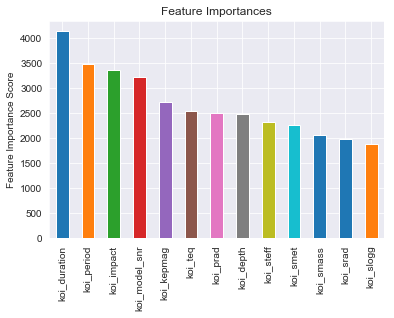

In [286]:
xgb2 = XGBClassifier(learning_rate=0.01,
                     n_estimators=2000,
                     max_depth=6,
                     min_child_weight=2,
                     gamma=0.1,
                     subsample=0.85,
                     colsample_bytree=0.8,
                     reg_alpha=0,
                     reg_lambda=0.9,
                     objective= 'binary:logistic',
                     nthread=4,
                     scale_pos_weight=1,
                     seed=42)
modelfit(xgb2, X_train, y_train.koi_pdisposition.values,
         X_test, y_test.koi_pdisposition.values, 2000)

# How is ***this*** the best test accuracy I've gotten?!?!